# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw08_boosting_clustering/ds_salaries.csv")
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [5]:
from sklearn.model_selection import train_test_split

y = data['salary_in_usd']

X = data.drop(columns=['salary', 'salary_in_usd']) #убираем salary, так как это тот же таргет только с поправкой на курс, и из-за этого будет лик в данных

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


***Никто не говорил про регуляризацию***

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['experience_level', 'employment_type', 'salary_currency', 'job_title', 'employee_residence', 'company_location', 'company_size']
numerical_features = ['work_year', 'remote_ratio']

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

train_encoded_cat = encoder.fit_transform(X_train[categorical_features])
X_train = np.hstack((X_train[numerical_features].values, train_encoded_cat))

val_encoded_cat = encoder.transform(X_val[categorical_features])
X_val = np.hstack((X_val[numerical_features].values, val_encoded_cat))

test_encoded_cat = encoder.transform(X_test[categorical_features])
X_test = np.hstack((X_test[numerical_features].values, test_encoded_cat))

model = LinearRegression()
model.fit(X_train, y_train)

val_predictions = model.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, val_predictions)
val_rmse = mean_squared_error(y_val, val_predictions, squared=False)

test_predictions = model.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print('MAPE на валидационной выборке: ', val_mape)
print('RMSE на валидационной выборке: ', val_rmse)

print('MAPE на тестовой выборке: ', test_mape)
print('RMSE на тестовой выборке: ', test_rmse)

MAPE на валидационной выборке:  20971612.58526623
RMSE на валидационной выборке:  6046076645091.2705
MAPE на тестовой выборке:  3691883.234464157
RMSE на тестовой выборке:  808259493379.4722


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [7]:
from xgboost import XGBRegressor
import time

param_ranges = {
    'max_depth': range(1, 9, 2),
    'learning_rate': np.linspace(0.01, 1, 5),
    'n_estimators': range(1, 21, 4),
    'gamma': np.linspace(0.001, 1, 5)
}

best_mape = float('inf')
best_params = {}

start_time = time.time()

for max_depth in param_ranges['max_depth']:
    for learning_rate in param_ranges['learning_rate']:
        for n_estimators in param_ranges['n_estimators']:
            for gamma in param_ranges['gamma']:
                xgb_model = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate,
                                         n_estimators=n_estimators, gamma=gamma, random_state=42)
                xgb_model.fit(X_train, y_train)
                val_predictions = xgb_model.predict(X_val)
                val_mape = mean_absolute_percentage_error(y_val, val_predictions)
                if val_mape < best_mape:
                    best_mape = val_mape
                    best_params = {'max_depth': max_depth, 'learning_rate': learning_rate,
                                   'n_estimators': n_estimators, 'gamma': gamma}

end_time = time.time()
param_pick_time = end_time - start_time
print('Время подбора параметров: ', param_pick_time)

print('Лучшие параметры:', best_params)
best_xgb_model = XGBRegressor(**best_params, random_state=42)
start_time = time.time()
best_xgb_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print('Время обучения: ', training_time)

val_predictions = best_xgb_model.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, val_predictions)
val_rmse = mean_squared_error(y_val, val_predictions, squared=False)

start_time = time.time()
test_predictions = best_xgb_model.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
print('Время предсказания: ', prediction_time)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print('MAPE на валидационной выборке: ', val_mape)
print('RMSE на валидационной выборке: ', val_rmse)
print('MAPE на тестовой выборке: ', test_mape)
print('RMSE на тестовой выборке: ', test_rmse)

Время подбора параметров:  36.89048385620117
Лучшие параметры: {'max_depth': 7, 'learning_rate': 0.505, 'n_estimators': 17, 'gamma': 0.001}
Время обучения:  0.07315540313720703
Время предсказания:  0.0012731552124023438
MAPE на валидационной выборке:  0.37785172055249766
RMSE на валидационной выборке:  45834.6341574473
MAPE на тестовой выборке:  0.33966115527538704
RMSE на тестовой выборке:  50828.29690668072


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [8]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.0 MB/s eta 0:00:00


In [9]:
from catboost import CatBoostRegressor

param_ranges = {
    'depth': range(2, 9, 2),
    'learning_rate': np.linspace(0.001, 0.5, 5),
    'iterations': range(50, 251, 50),
    'l2_leaf_reg': np.linspace(1, 10, 5),
}

best_mape = float('inf')
best_params = {}


start_time = time.time()

for depth in param_ranges['depth']:
    for learning_rate in param_ranges['learning_rate']:
        for iterations in param_ranges['iterations']:
            for l2_leaf_reg in param_ranges['l2_leaf_reg']:
                catboost_model = CatBoostRegressor(depth=depth, learning_rate=learning_rate,
                                                    iterations=iterations, l2_leaf_reg=l2_leaf_reg, random_seed=42, silent=True)
                catboost_model.fit(X_train, y_train)
                val_predictions = catboost_model.predict(X_val)
                val_mape = mean_absolute_percentage_error(y_val, val_predictions)
                if val_mape < best_mape:
                    best_mape = val_mape
                    best_params = {'depth': depth, 'learning_rate': learning_rate,
                                   'iterations': iterations, 'l2_leaf_reg': l2_leaf_reg}

end_time = time.time()
param_pick_time = end_time - start_time
print('Время подбора параметров: ', param_pick_time)

print('Лучшие параметры:', best_params)
best_catboost_model = CatBoostRegressor(**best_params, random_seed=42, silent=True)
start_time = time.time()
best_catboost_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print('Время обучения: ', training_time)

val_predictions = best_catboost_model.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, val_predictions)
val_rmse = mean_squared_error(y_val, val_predictions, squared=False)

test_predictions = best_catboost_model.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

start_time = time.time()
test_predictions = best_catboost_model.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
print('Время предсказания: ', prediction_time)

print('MAPE на валидационной выборке: ', val_mape)
print('RMSE на валидационной выборке: ', val_rmse)
print('MAPE на тестовой выборке: ', test_mape)
print('RMSE на тестовой выборке: ', test_rmse)

Время подбора параметров:  337.3176987171173
Лучшие параметры: {'depth': 4, 'learning_rate': 0.5, 'iterations': 200, 'l2_leaf_reg': 5.5}
Время обучения:  0.8629653453826904
Время предсказания:  0.05594348907470703
MAPE на валидационной выборке:  0.37851518998845163
RMSE на валидационной выборке:  44930.03308983754
MAPE на тестовой выборке:  0.3485988942417457
RMSE на тестовой выборке:  50816.87858253071


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [12]:
from catboost import Pool

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_test_1, y_test_1, test_size=0.5, random_state=42)

categorical_features = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']

train_pool = Pool(data=X_train_1, label=y_train_1, cat_features=categorical_features)
val_pool = Pool(data=X_val_1, label=y_val_1, cat_features=categorical_features)
test_pool = Pool(data=X_test_1, label=y_test_1, cat_features=categorical_features)

param_ranges = {
    'depth': range(2, 9, 2),
    'learning_rate': np.linspace(0.001, 0.5, 5),
    'iterations': range(50, 251, 50),
    'l2_leaf_reg': np.linspace(1, 10, 5),
}

best_mape = float('inf')
best_params = {}

start_time = time.time()

for depth in param_ranges['depth']:
    for learning_rate in param_ranges['learning_rate']:
        for iterations in param_ranges['iterations']:
            for l2_leaf_reg in param_ranges['l2_leaf_reg']:
                catboost_model = CatBoostRegressor(depth=depth, learning_rate=learning_rate,
                                                    iterations=iterations, l2_leaf_reg=l2_leaf_reg, random_seed=42, silent=True)
                catboost_model.fit(train_pool)
                val_predictions = catboost_model.predict(val_pool)
                val_mape = mean_absolute_percentage_error(y_val, val_predictions)
                if val_mape < best_mape:
                    best_mape = val_mape
                    best_params = {'depth': depth, 'learning_rate': learning_rate,
                                   'iterations': iterations, 'l2_leaf_reg': l2_leaf_reg}

end_time = time.time()
param_pick_time = end_time - start_time
print('Время подбора параметров: ', param_pick_time)

print('Лучшие параметры:', best_params)
best_catboost_model = CatBoostRegressor(**best_params, random_seed=42, silent=True)
start_time = time.time()
best_catboost_model.fit(train_pool)
end_time = time.time()
training_time = end_time - start_time
print('Время обучения: ', training_time)

val_predictions = best_catboost_model.predict(val_pool)
val_mape = mean_absolute_percentage_error(y_val, val_predictions)
val_rmse = mean_squared_error(y_val, val_predictions, squared=False)

test_predictions = best_catboost_model.predict(test_pool)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

start_time = time.time()
test_predictions = best_catboost_model.predict(test_pool)
end_time = time.time()
prediction_time = end_time - start_time
print('Время предсказания: ', prediction_time)

print('MAPE на валидационной выборке: ', val_mape)
print('RMSE на валидационной выборке: ', val_rmse)
print('MAPE на тестовой выборке: ', test_mape)
print('RMSE на тестовой выборке: ', test_rmse)

Время подбора параметров:  395.751188993454
Лучшие параметры: {'depth': 6, 'learning_rate': 0.5, 'iterations': 150, 'l2_leaf_reg': 1.0}
Время обучения:  0.4009737968444824
Время предсказания:  0.0007791519165039062
MAPE на валидационной выборке:  0.39902428936924783
RMSE на валидационной выборке:  46808.63138726586
MAPE на тестовой выборке:  0.3858692619552997
RMSE на тестовой выборке:  51768.620618427405


**Ответ:** Я делал сначала в юпитере, а потом у меня никак не грузился LGBM и я перешел в колаб. В юпитере pool работает быстрее (и обучается, и подбирает параметры), а в колабе дольше параметры подбираются, быстрее обучаются. Качество у pool хуже было везде.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [13]:
from lightgbm import LGBMRegressor

In [14]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

param_ranges = {
    'max_depth': range(1, 5),
    'learning_rate': np.linspace(0.001, 0.5, 5),
    'n_estimators': range(50, 251, 50),
    'reg_lambda': np.linspace(0.1, 10, 5),
}

best_mape = float('inf')
best_params = {}

start_time = time.time()

for max_depth in param_ranges['max_depth']:
    for learning_rate in param_ranges['learning_rate']:
        for n_estimators in param_ranges['n_estimators']:
            for reg_lambda in param_ranges['reg_lambda']:
                lgbm_model = LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate,
                                           n_estimators=n_estimators, reg_lambda=reg_lambda, random_state=42, verbose=-1)
                lgbm_model.fit(X_train, y_train)
                val_predictions = lgbm_model.predict(X_val)
                val_mape = mean_absolute_percentage_error(y_val, val_predictions)
                if val_mape < best_mape:
                    best_mape = val_mape
                    best_params = {'max_depth': max_depth, 'learning_rate': learning_rate,
                                   'n_estimators': n_estimators, 'reg_lambda': reg_lambda}

end_time = time.time()
param_pick_time = end_time - start_time
print('Время подбора параметров: ', param_pick_time)

print('Лучшие параметры:', best_params)
best_lgbm_model = LGBMRegressor(**best_params, random_state=42, verbose=-1)
start_time = time.time()
best_lgbm_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print('Время обучения: ', training_time)

val_predictions = best_lgbm_model.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, val_predictions)
val_rmse = mean_squared_error(y_val, val_predictions, squared=False)

test_predictions = best_lgbm_model.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

start_time = time.time()
test_predictions = best_lgbm_model.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
print('Время предсказания: ', prediction_time)

print('MAPE на валидационной выборке: ', val_mape)
print('RMSE на валидационной выборке: ', val_rmse)
print('MAPE на тестовой выборке: ', test_mape)
print('RMSE на тестовой выборке: ', test_rmse)


Время подбора параметров:  21.281761169433594
Лучшие параметры: {'max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 50, 'reg_lambda': 2.575}
Время обучения:  0.019396305084228516
Время предсказания:  0.00164031982421875
MAPE на валидационной выборке:  0.3808721804913757
RMSE на валидационной выборке:  45577.346052824614
MAPE на тестовой выборке:  0.32794699149681905
RMSE на тестовой выборке:  49833.38127303001


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** Самый лучший результат и по качеству, и по скорости обучения, и по скорости предсказания показал LightGBM.

Оптимальный learning rate везде примерно одинаковый вышел, max_depth везде разный, как и iterations/n_estimators (где был), тоже различаются. Остальные гиперпараметры разные

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [15]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [16]:
ratings = ratings.T
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [17]:
ratings = ratings.drop('user')
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [18]:
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
prefuse 73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state=42)
kmeans.fit(ratings)

labels = kmeans.labels_
print(labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[3 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [20]:
df_clusters = pd.DataFrame({'artist': ratings.index, 'cluster': labels})

cluster_sizes = df_clusters['cluster'].value_counts()
print("Размеры кластеров:")
print(cluster_sizes)

Размеры кластеров:
cluster
2    995
0      2
3      1
4      1
1      1
Name: count, dtype: int64


**Ответ:** кластеризация не получилась от слова совсем. Возможно, причины в данных и наличии объектов, которые сильно отличается(KMeans чувствителен к выбросам), а также неоптимальное число кластеров. Также KMeans чувствителен к начальному выбору центроидов, и разные начальные позиции центроидов могут привести к различным конечным решениям (плохим локальным минимумам).

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [21]:
clusters_of_size_1 = cluster_sizes[cluster_sizes == 1].index
artists_in_size_1_clusters = df_clusters[df_clusters['cluster'].isin(clusters_of_size_1)]['artist']

print("\nИсполнители в кластерах размера 1:")
print(artists_in_size_1_clusters.values)


Исполнители в кластерах размера 1:
['the beatles' 'coldplay' '보아']


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [22]:
listeners_percentage = ratings.mean(axis=1)

print("Доля пользователей, которые слушают каждого исполнителя:")
print(listeners_percentage)

mean_listening_percentage_beatles = listeners_percentage['the beatles']
print("Средняя доля прослушивания для группы The Beatles:", mean_listening_percentage_beatles)


Доля пользователей, которые слушают каждого исполнителя:
the beatles           0.018369
radiohead             0.011851
deathcab for cutie    0.006543
coldplay              0.006030
modest mouse          0.005876
                        ...   
michal w. smith       0.000895
群星                    0.000519
agalloch              0.000997
meshuggah             0.000431
yellowcard            0.000320
Length: 1000, dtype: float64
Средняя доля прослушивания для группы The Beatles: 0.01836897659205146


**Ответ:** у The Beatles самая большая доля слушателей, и она сильно больше, чем у остальных.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [23]:
from sklearn.preprocessing import normalize

ratings_normalized = normalize(ratings)


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [24]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(ratings_normalized)

labels = kmeans.labels_

cluster_sizes = pd.Series(labels).value_counts()
print(cluster_sizes)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2    405
0    237
1    152
3    139
4     67
Name: count, dtype: int64


**Ответ:** стало сильно лучше, кластеры стали гораздо более сбалансированными. Кажется, кластеризация может быть очень полезной.

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [25]:
from scipy.spatial.distance import cosine

centroids = kmeans.cluster_centers_
artists = ratings.values
artists_names = ratings.index


def top_similar_artists_to_centroid(cluster_centroid, artists, artists_names, n=10):
    distances = [cosine(cluster_centroid, artist_vector) for artist_vector in artists]
    sorted_indices = sorted(range(len(distances)), key=lambda i: distances[i])
    top_similar_indices = sorted_indices[:n]
    return [artists_names[i] for i in top_similar_indices]

for i in range(centroids.shape[0]):
    print(f"Кластер {i + 1}:")
    top_artists = top_similar_artists_to_centroid(centroids[i], artists, artists_names)
    for j, artist in enumerate(top_artists):
        print(f"{j + 1}. {artist}")
    print()


Кластер 1:
1. radiohead
2. the arcade fire
3. broken social scene
4. animal collective
5. belle and sebastian
6. sufjan stevens
7. the shins
8. of montreal
9. the pixies
10. spoon

Кластер 2:
1. kelly clarkson
2. rihanna & jay-z
3. maroon5
4. the pussycat dolls
5. john mayer
6. alicia keys
7. lady gaga
8. beyoncé
9. coldplay
10. nelly furtado

Кластер 3:
1. the beatles
2. the rolling stones
3. led zeppelin.
4. pink fluid
5. acdc
6. metallica
7. radiohead
8. red hot clili peppers
9. the clash
10. queen

Кластер 4:
1. fall out boy
2. saosin
3. brand new
4. taking back sunday
5. blink-182
6. anberlin
7. the used
8. cartel
9. chiodos
10. new found glory

Кластер 5:
1. nas
2. jay-z
3. a tribe called quest
4. kanye west
5. the roots featuring d'angelo
6. lupe the gorilla
7. gangstarr
8. murs and 9th wonder
9. little brother
10. mos def



**Ответ:** кластеры разделены по жанрам: 1) альт рок; 2) поп; 3) рок; 4) хардкор(не уверен), 5) рэп.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

In [26]:
import pandas as pd
cluster_df = pd.DataFrame({'Artist': ratings.index, 'Cluster': labels})
cluster_df.head()

,Artist,Cluster
0,the beatles,2
1,radiohead,0
2,deathcab for cutie,0
3,coldplay,1
4,modest mouse,0


In [27]:
ratings_t = ratings.T

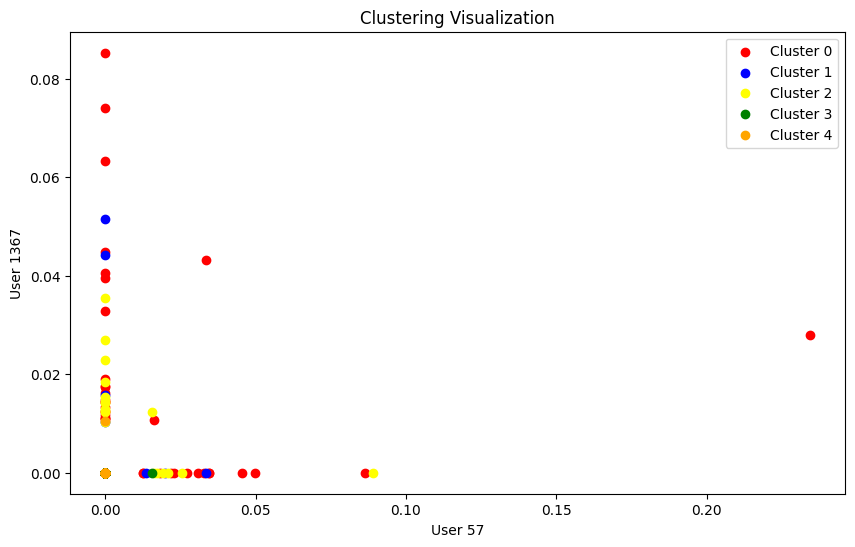

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

colors = ['red', 'blue', 'yellow', 'green', 'orange']

for cluster_label in range(5):
    cluster_artists = cluster_df[cluster_df['Cluster'] == cluster_label]['Artist']
    cluster_points = ratings_t.T.loc[cluster_artists]
    plt.scatter(cluster_points[57], cluster_points[1367], label=f'Cluster {cluster_label}', color=colors[cluster_label])

plt.xlabel('User 57')
plt.ylabel('User 1367')
plt.title('Clustering Visualization')

plt.legend()
plt.show()

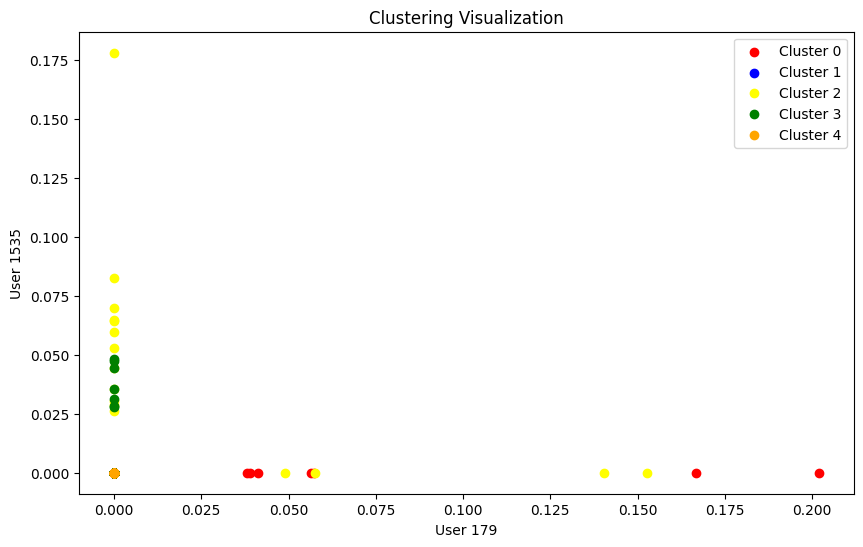

In [29]:
plt.figure(figsize=(10, 6))

colors = ['red', 'blue', 'yellow', 'green', 'orange']

for cluster_label in range(5):
    cluster_artists = cluster_df[cluster_df['Cluster'] == cluster_label]['Artist']
    cluster_points = ratings_t.T.loc[cluster_artists]
    plt.scatter(cluster_points[179], cluster_points[1535], label=f'Cluster {cluster_label}', color=colors[cluster_label])

plt.xlabel('User 179')
plt.ylabel('User 1535')
plt.title('Clustering Visualization')

plt.legend()
plt.show()

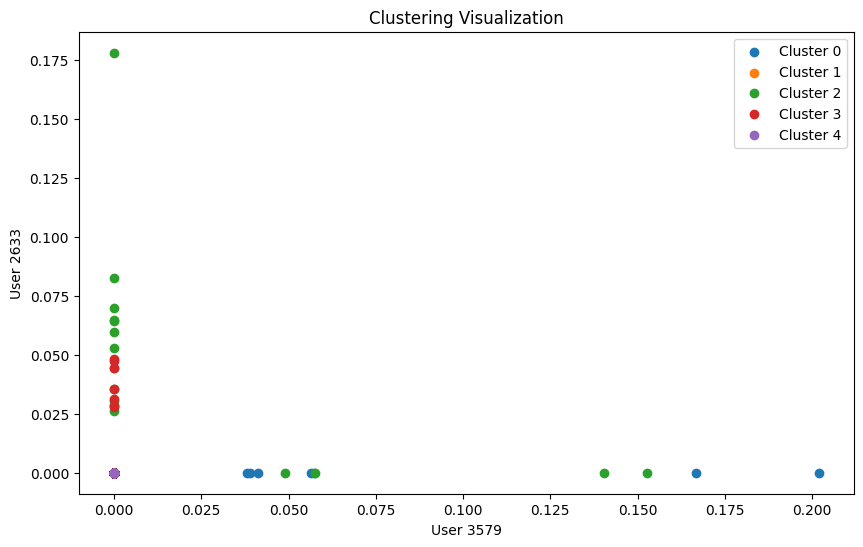

In [30]:
plt.figure(figsize=(10, 6))

for cluster_label in range(5):
    cluster_artists = cluster_df[cluster_df['Cluster'] == cluster_label]['Artist']
    cluster_points = ratings_t.T.loc[cluster_artists]
    plt.scatter(cluster_points[179], cluster_points[1535], label=f'Cluster {cluster_label}')

plt.xlabel('User 3579')
plt.ylabel('User 2633')
plt.title('Clustering Visualization')

plt.legend()
plt.show()

**Ответ:** Это ужасно. Очень многих точек нет, а остальные разбиты очень случайно, и от этого нет никакого смысла.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

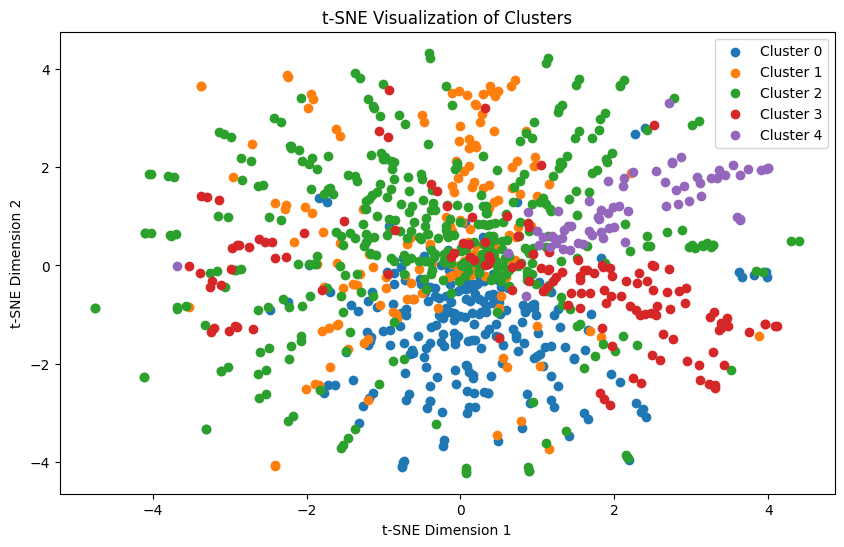

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

tsne_results = tsne.fit_transform(ratings)

plt.figure(figsize=(10, 6))
for cluster_label in range(5):
    cluster_points = tsne_results[labels == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label}')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Clusters')

plt.legend()
plt.show()


## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

**Я считал, что надо делать на нормализовыванных данных.**

код работает 17 минут;))

In [32]:
from sklearn.metrics import silhouette_score

max_clusters = 100
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters = n_clusters, n_init=10, random_state=42)
    kmeans.fit(ratings_normalized)
    labels = kmeans.labels_

    silhouette = silhouette_score(ratings_normalized, labels)
    silhouette_scores.append(silhouette)
    print(n_clusters, silhouette)


optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

print(f"Оптимальное количество кластеров: {optimal_num_clusters}")



2 0.004435467122570446
3 0.005315820445524468
4 0.006557296738510863
5 0.006837938191539542
6 0.007482359393187097
7 0.007912084817600714
8 0.00699610257418764
9 0.00692453596232229
10 0.007656172023778919
11 0.007653981096285085
12 0.007159948785940884
13 0.007846976552377318
14 0.006683412647278718
15 0.007925642156739573
16 0.007596891038694203
17 0.007475218805144922
18 0.007705788383756331
19 0.006920292037007385
20 0.007575977220563942
21 0.007759706207656011
22 0.006870381289211506
23 0.008271718956586982
24 0.0077320394739924725
25 0.008403475738341477
26 0.007483838855246243
27 0.007754129081057446
28 0.007004376690159677
29 0.007066496572794938
30 0.006523738685078842
31 0.005958974931576261
32 0.007015953324793824
33 0.007131408660686132
34 0.0062518292242094995
35 0.0070313419605880735
36 0.00710985012826629
37 0.0069715756170788176
38 0.007734987006582815
39 0.006652357790592273
40 0.007732867717220969
41 0.007614105671136561
42 0.0074417453027095645
43 0.00801962320523001

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [36]:
kmeans = KMeans(n_clusters=optimal_num_clusters, n_init=10, random_state=42)
kmeans.fit(ratings_normalized)
labels = kmeans.labels_
cluster_sizes = pd.Series(labels).value_counts()

centroids = kmeans.cluster_centers_
artists = ratings.values
artists_names = ratings.index

def top_similar_artists_to_centroid(cluster_centroid, cluster_points, cluster_names, n=10):
    distances = [cosine(cluster_centroid, artist_vector) for artist_vector in cluster_points]
    sorted_indices = sorted(range(len(distances)), key=lambda i: distances[i])
    top_similar_indices = sorted_indices[:n]
    return [cluster_names[i] for i in top_similar_indices]

for cluster_label in range(optimal_num_clusters):
    print(f"Кластер {cluster_label + 1}:")
    cluster_indices = [i for i, label in enumerate(labels) if label == cluster_label]
    cluster_points = artists[cluster_indices]
    cluster_names = artists_names[cluster_indices]
    top_artists = top_similar_artists_to_centroid(centroids[cluster_label], cluster_points, cluster_names)
    for j, artist in enumerate(top_artists):
        print(f"{j + 1}. {artist}")
    print()

Кластер 1:
1. circa survive
2. portugal. the man
3. cursive
4. citya and colour
5. the blood brothers
6. coheed and cambria
7. four year strong
8. owen
9. why?
10. manchester orchestra

Кластер 2:
1. the brian jonestown massacre
2. spiritualized®
3. black rebel motorcycle club
4. the dandy warhols
5. the verve
6. silver jews

Кластер 3:
1. squarepusher.
2. autechre
3. amon tobin
4. boards of canada
5. aphex twin
6. prefuse 73
7. underworld
8. rjd2
9. burial
10. björk guğmunsdóttir

Кластер 4:
1. talib kweli
2. the roots featuring d'angelo
3. mos def
4. little brother
5. common
6. jurassic 5
7. cunninlynguists

Кластер 5:
1. mgmt
2. vampire weekend
3. tokyo police club
4. ratatat
5. kings of leon
6. the klaxons
7. justice
8. los campesinos!
9. the dodos
10. au rivoir simone

Кластер 6:
1. my bloody valentine
2. deerhunter
3. animal collective
4. slowdive
5. beach house
6. asobi seksu
7. liars
8. broadcast
9. pavement
10. the jesus and mary chain

Кластер 7:
1. destinys child
2. janet ja

**Ответ:** я все перерыл, но не нашел ничего "интересного" из кластеров или я плохо шарю за музыку (тут же не русский рэп/поп ахах). ну, полагаю, здесь схожесть по стилям еще больше стала, чем при 5 кластерах.

P.S. 88 кластер с крутым рэпом: Эминемом, Тупаком, 50 cent и dr. dre >>>
А еще 60 кластер с классической музыкой: Бах, Моцарт, Шопен, Вивальди прикольный

Сделайте t-SNE визуализацию полученной кластеризации.

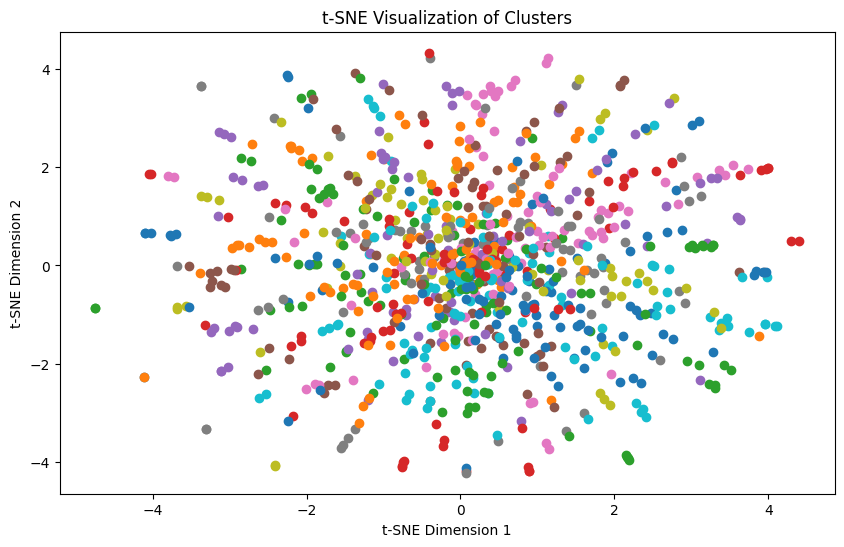

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

tsne_results = tsne.fit_transform(ratings)

plt.figure(figsize=(10, 6))
for cluster_label in range(optimal_num_clusters):
    cluster_points = tsne_results[labels == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label}')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Clusters')
#легенды не будет, она слишком большая
plt.show()


Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

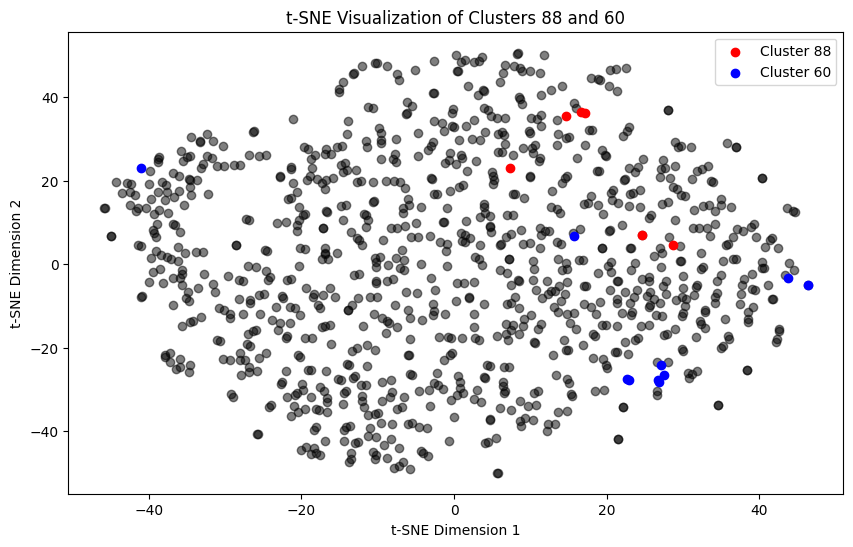

In [41]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(ratings_normalized)

plt.figure(figsize=(10, 6))

clusters_to_visualize = [88, 60]

for cluster_label in range(optimal_num_clusters):
    if cluster_label not in clusters_to_visualize:
        cluster_points = tsne_results[labels == cluster_label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color='black', alpha=0.5)

colors = ['red', 'blue']
for cluster_label, color in zip(clusters_to_visualize, colors):
    cluster_points = tsne_results[labels == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label}', color=color)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Clusters')
plt.legend()
plt.show()

**Ответ:** кластеры плохо отражаются в визуализации.